Imports

In [1]:
import numpy as np
from Reader import Reader as rd
import Camera
import SingleImage
from ImagePair import ImagePair
import pandas as pd
import matplotlib.pyplot as plt
import copy

Setting Parameters

In [2]:
y_size = 3648 # size of y axis of a picture
pix_s = 2.4e-3  #single pixel size (micron should be e-6)
focal = 4239.655*pix_s
ppoint = np.array([2746.295,1837.450])*pix_s
radial_d = np.array([0.0473,-0.414,])*pix_s
dece_d = np.array([-0.0014,-0.0028,0])*pix_s

Reading and Creating list of Homological points

In [3]:
list_of_raw_points = []
list_of_raw_points.append(rd.ReadSampleFile(r'colorbase/IMG_1793.json'))
list_of_raw_points.append(rd.ReadSampleFile(r'colorbase/IMG_1794.json'))
list_of_raw_points.append(rd.ReadSampleFile(r'colorbase/IMG_1795.json'))

Fixing camera axis 

In [4]:
list_of_y_fixed_points = copy.deepcopy(list_of_raw_points)
for m in range(len(list_of_raw_points)):
    for row in range(len(list_of_raw_points[m]-1)):
        list_of_y_fixed_points[m][row,1] = y_size -  list_of_raw_points[m][row,1]

Fixing camera center

In [5]:
list_of_y_center_fixed_points = copy.deepcopy(list_of_y_fixed_points)
for m in range(len(list_of_y_fixed_points)):
    for row in range(len(list_of_y_fixed_points[m]-1)):
        list_of_y_center_fixed_points[m][row,:] =\
        list_of_y_fixed_points[m][row,:] - ppoint/pix_s

Multiply by pixel size

In [6]:
list_of_y_center_fixed_mm_points = copy.deepcopy(list_of_y_center_fixed_points)
for m in range(len(list_of_y_center_fixed_points)):
    for row in range(len(list_of_y_center_fixed_points[m]-1)):
        list_of_y_center_fixed_mm_points[m][row,:] =\
        list_of_y_center_fixed_points[m][row,:]*pix_s

Creating pairs of point sets

In [7]:
pointset12 = [list_of_raw_points[0],list_of_raw_points[1]]
pointset23 = [list_of_raw_points[1],list_of_raw_points[2]]

Creating camera objects, we entering raw points of color surface as fudicals

In [8]:
camera1 = Camera.Camera(focal,ppoint,radial_d,dece_d,list_of_y_center_fixed_mm_points[0])
camera2 = Camera.Camera(focal,ppoint,radial_d,dece_d,list_of_y_center_fixed_mm_points[1])
camera3 = Camera.Camera(focal,ppoint,radial_d,dece_d,list_of_y_center_fixed_mm_points[2])

Creating Image Objects

In [9]:
img1 = SingleImage.SingleImage(camera1)
img2 = SingleImage.SingleImage(camera2)
img3 = SingleImage.SingleImage(camera3)

Calculating inner orientation

In [10]:
inner_orient_img1 = img1.ComputeInnerOrientation(list_of_raw_points[0])
inner_orient_img2 = img2.ComputeInnerOrientation(list_of_raw_points[1])
inner_orient_img3 = img3.ComputeInnerOrientation(list_of_raw_points[2])

Creating Image pair objects

In [11]:
img_pair_1 = ImagePair(img1,img2)
img_pair_2 = ImagePair(img2,img3)

Calculating relative orientation

In [12]:
initial_p = np.array([0.0,0.0,0.0,0.0,0.0])
relative_ori_1,sigma12 = img_pair_1.ComputeDependentRelativeOrientation(list_of_y_center_fixed_mm_points[0],\
                                                                list_of_y_center_fixed_mm_points[1],\
                                                                initial_p)
relative_ori_2,sigma23 = img_pair_2.ComputeDependentRelativeOrientation(list_of_y_center_fixed_mm_points[1],\
                                                                list_of_y_center_fixed_mm_points[2],\
                                                                initial_p)

          0         1         2         3         4
0  2.794105  2.202148  1.546451  0.097467  0.033793
1  2.202148  2.099709  1.210228 -0.324227  0.034524
2  1.546451  1.210228  0.857504  0.058484  0.020108
3  0.097467 -0.324227  0.058484  0.753002 -0.078626
4  0.033793  0.034524  0.020108 -0.078626  0.039715
          0         1         2         3         4
0  3.183960  2.487720  1.184019  0.355954  0.142040
1  2.487720  4.941017  0.585605 -3.816441  0.099597
2  1.184019  0.585605  0.485321  0.669170  0.051109
3  0.355954 -3.816441  0.669170  6.650865 -0.007075
4  0.142040  0.099597  0.051109 -0.007075  0.028327


Calculating relative model coordinates of object

In [13]:
object_points = []
object_points.append(rd.ReadSampleFile(r'colorbase/boxespic2.json'))
object_points.append(rd.ReadSampleFile(r'colorbase/boxespic3.json'))

world_model_points = img_pair_1.ImagesToGround(object_points[0],\
                                               object_points[1])

print(pd.DataFrame(world_model_points[0]))

          0         1         2
0  0.541260 -0.000376  0.022643
1  0.538151  0.025024  0.010559
2  0.526154  0.018342  0.017307
3  0.490442 -0.008144  0.041294
4  0.521541 -0.010129  0.032858
5  0.518057 -0.012864  0.035414
6  0.489416 -0.007782  0.041389
7  0.524465  0.014534  0.019122
8  0.537520 -0.003349  0.025221


Plotting the results

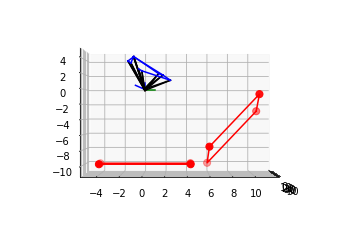

In [14]:
img_pair_2.drawImagePair(img_pair_2,world_model_points[0])